The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


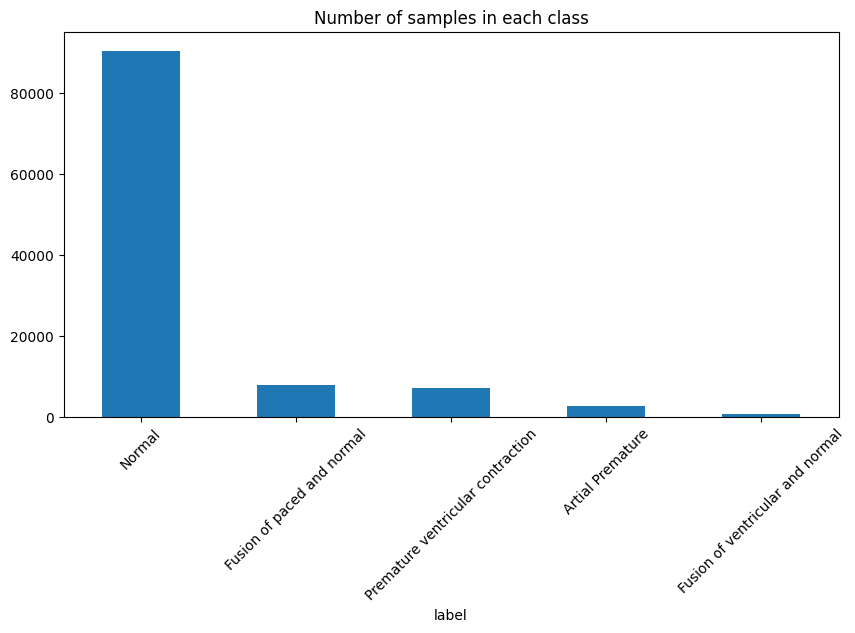

In [4]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

df_mitbih_train = pd.read_csv("../data/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("../data/mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()

# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

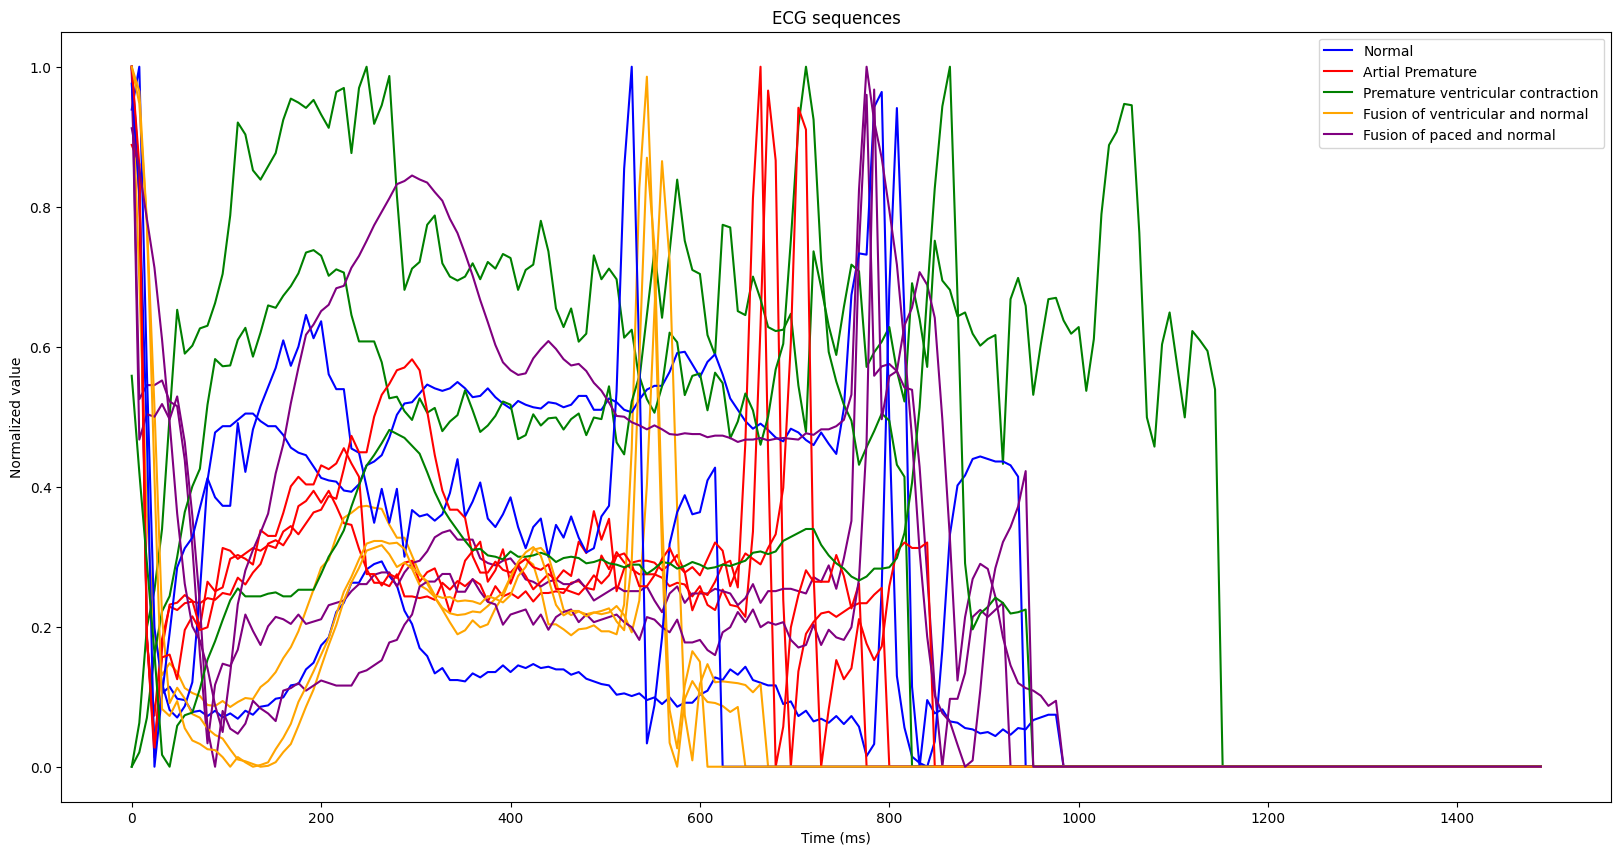

In [5]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [6]:
# Partitioning the data
from sklearn.model_selection import train_test_split # type: ignore
import tensorflow as tf # type: ignore

# split the data into training and testing
# 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(df_mitbih.iloc[:, :-1], df_mitbih.iloc[:, -1], test_size = 0.20, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.75, random_state = 42)

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

In [8]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input, BatchNormalization, Activation # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.metrics import CategoricalAccuracy # type: ignore

def build_model(num_classes=5):
    input_layer = Input(shape=(X_train.shape[1], 1))
    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name='last_conv')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
    return model    

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 187, 128)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 187, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 187, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 187, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv1D)              │ (None, 187, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,373 (1.02 MB)

 Trainable params: 265,349 (1.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [9]:
class_weights

{0: 0.2417705615154151,
 1: 7.803565062388592,
 2: 3.001576962632842,
 3: 27.149147286821705,
 4: 2.734415990006246}

In [11]:
history = model.fit(
    X_train, y_train, # type: ignore
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val), # type: ignore
    class_weight=class_weights # type: ignore
)

Epoch 1/100
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 155s 57ms/step - categorical_accuracy: 0.7533 - loss: 0.5525 - val_categorical_accuracy: 0.6741 - val_loss: 0.8871
Epoch 2/100
  57/2737 ━━━━━━━━━━━━━━━━━━━━ 3:00 67ms/step - categorical_accuracy: 0.8249 - loss: 0.2314

KeyboardInterrupt: 

In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.8340 - loss: 0.5151
Test accuracy: 0.8353
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


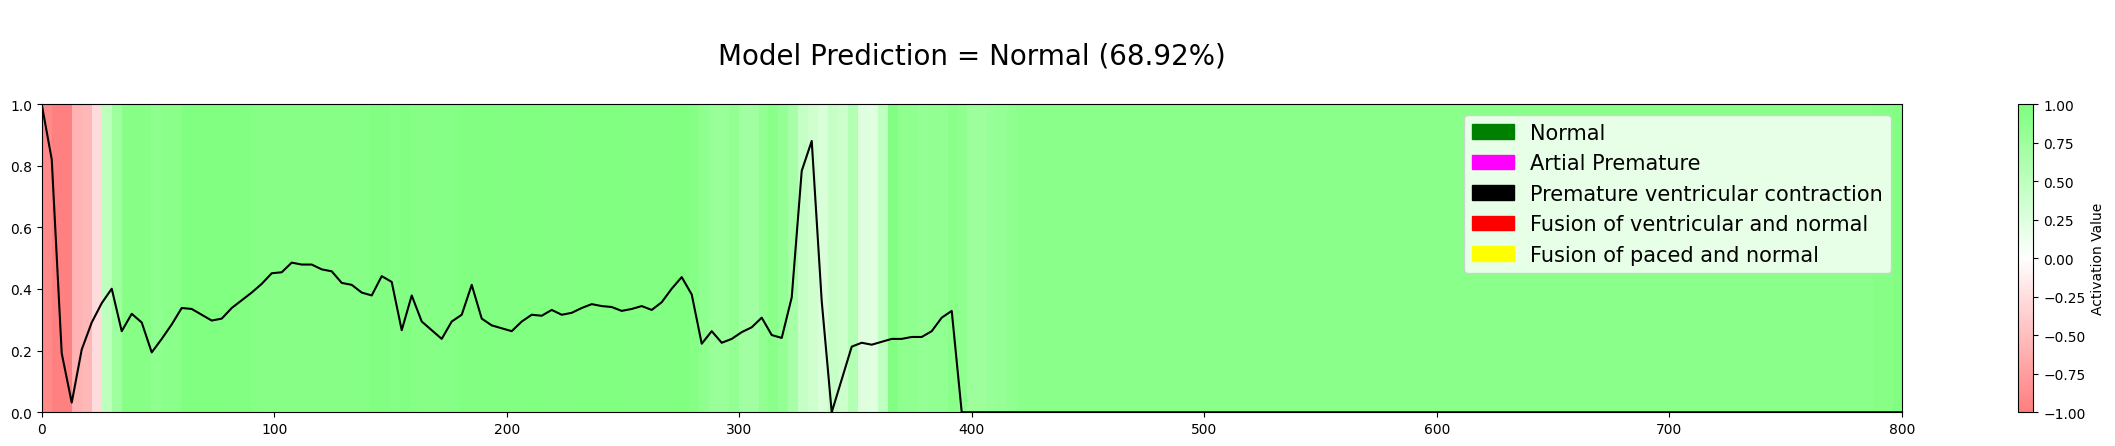

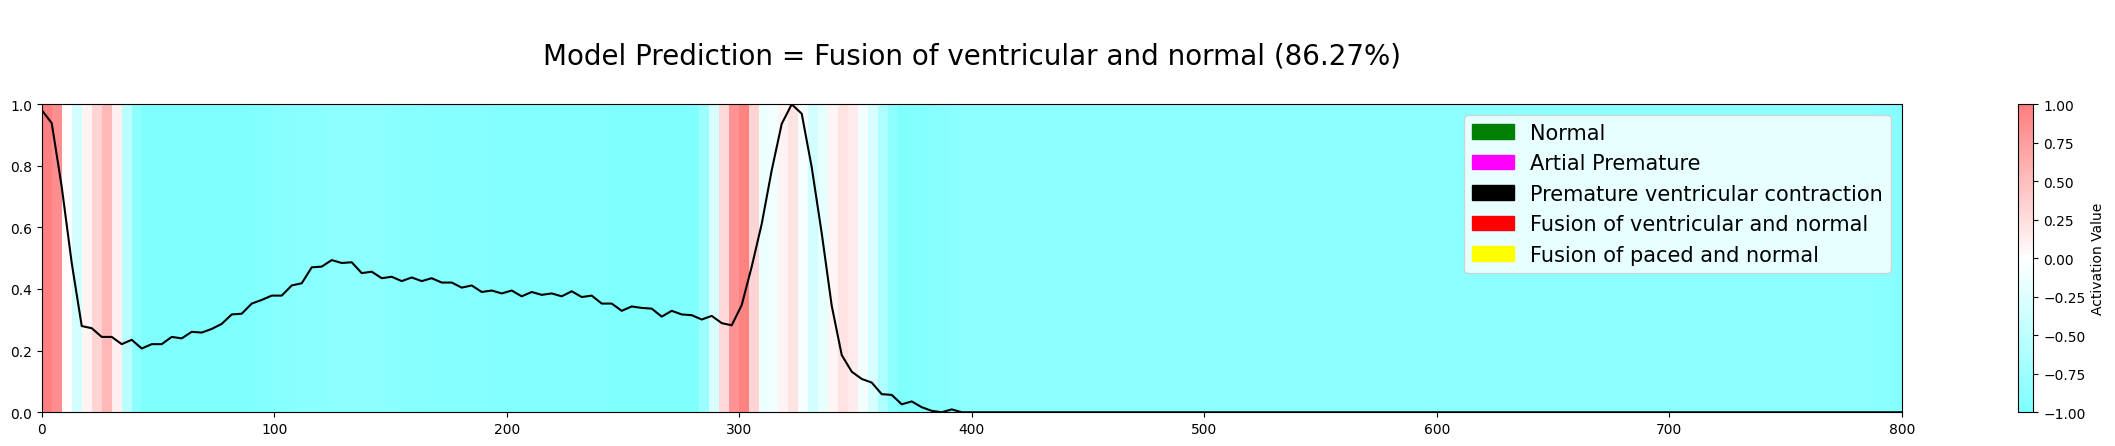

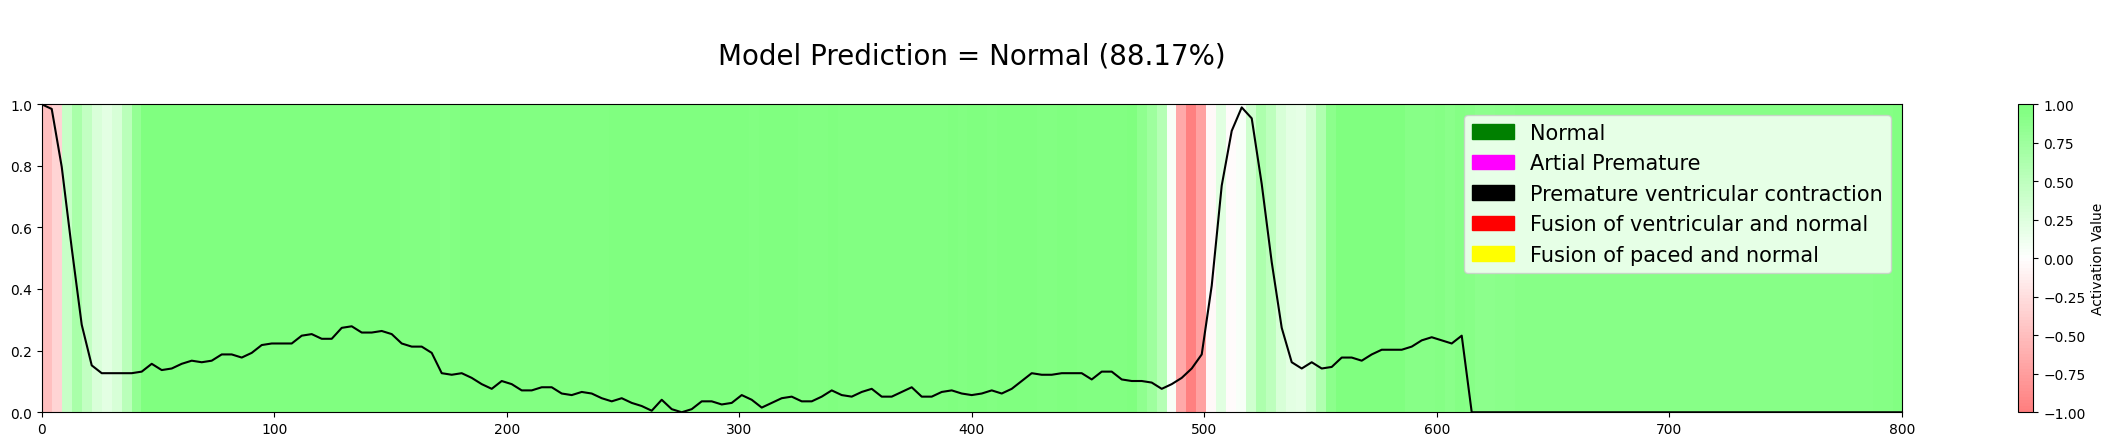

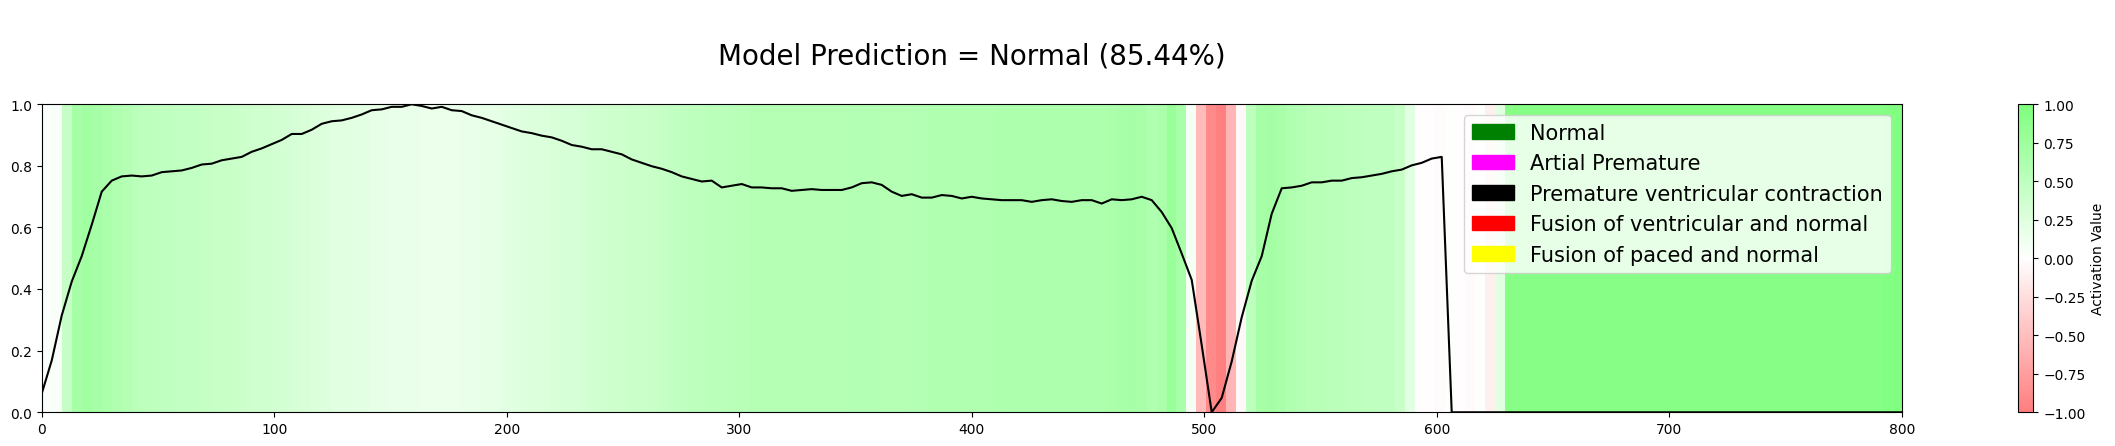

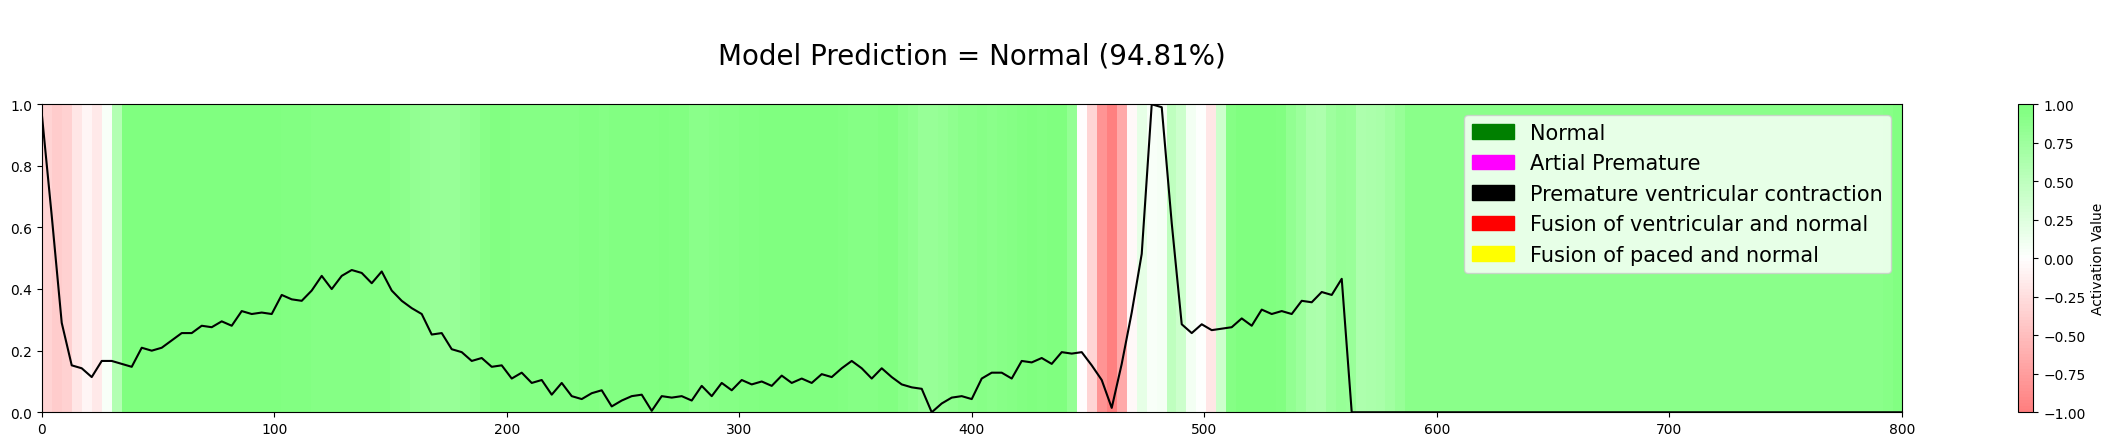

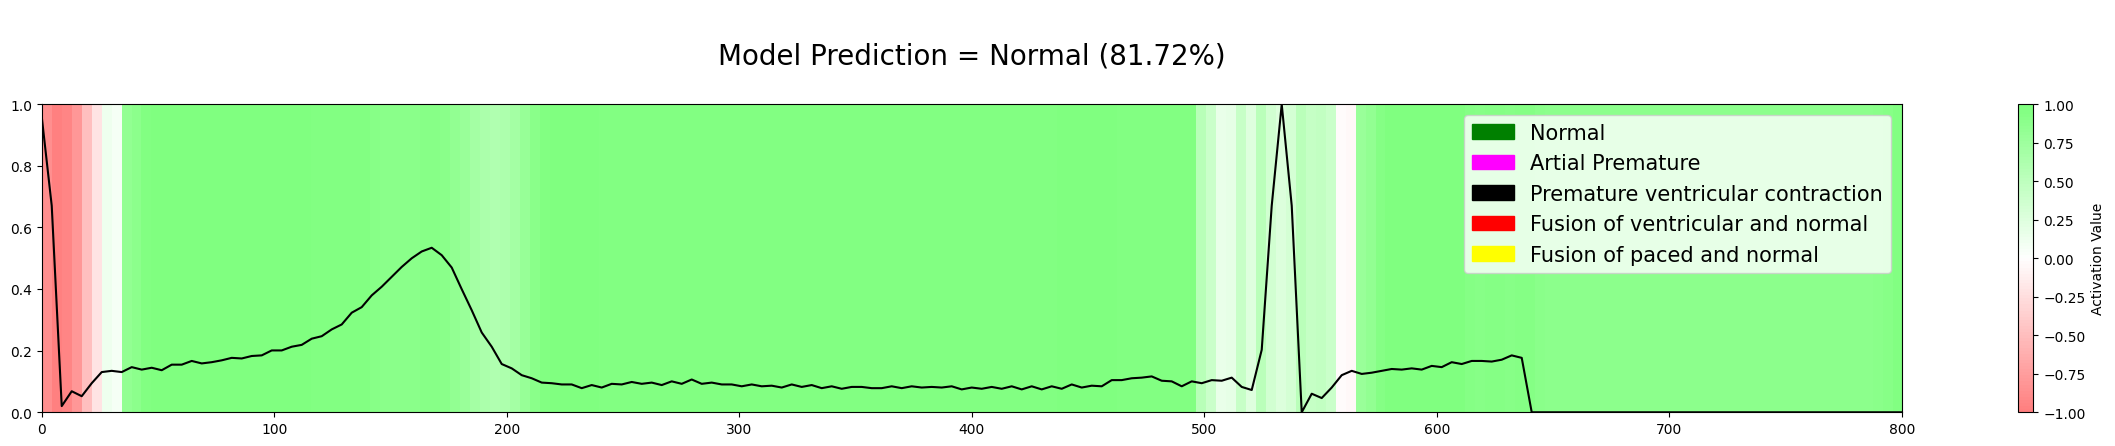

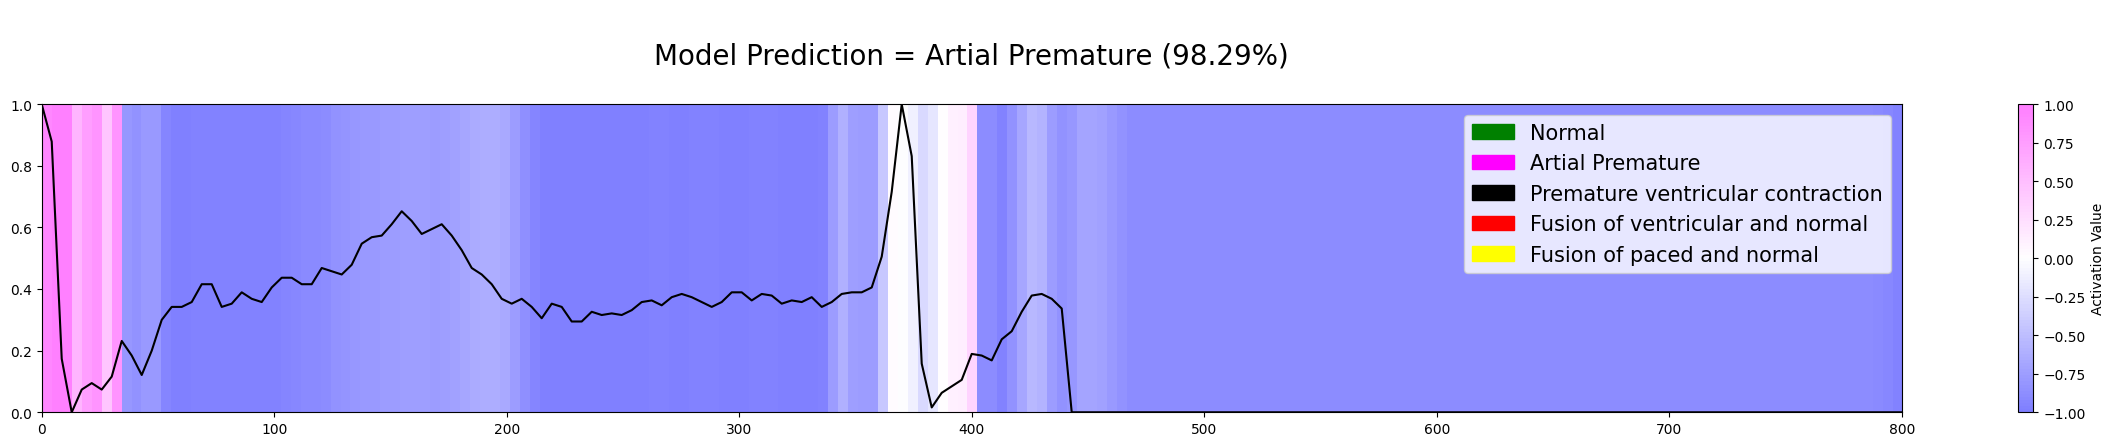

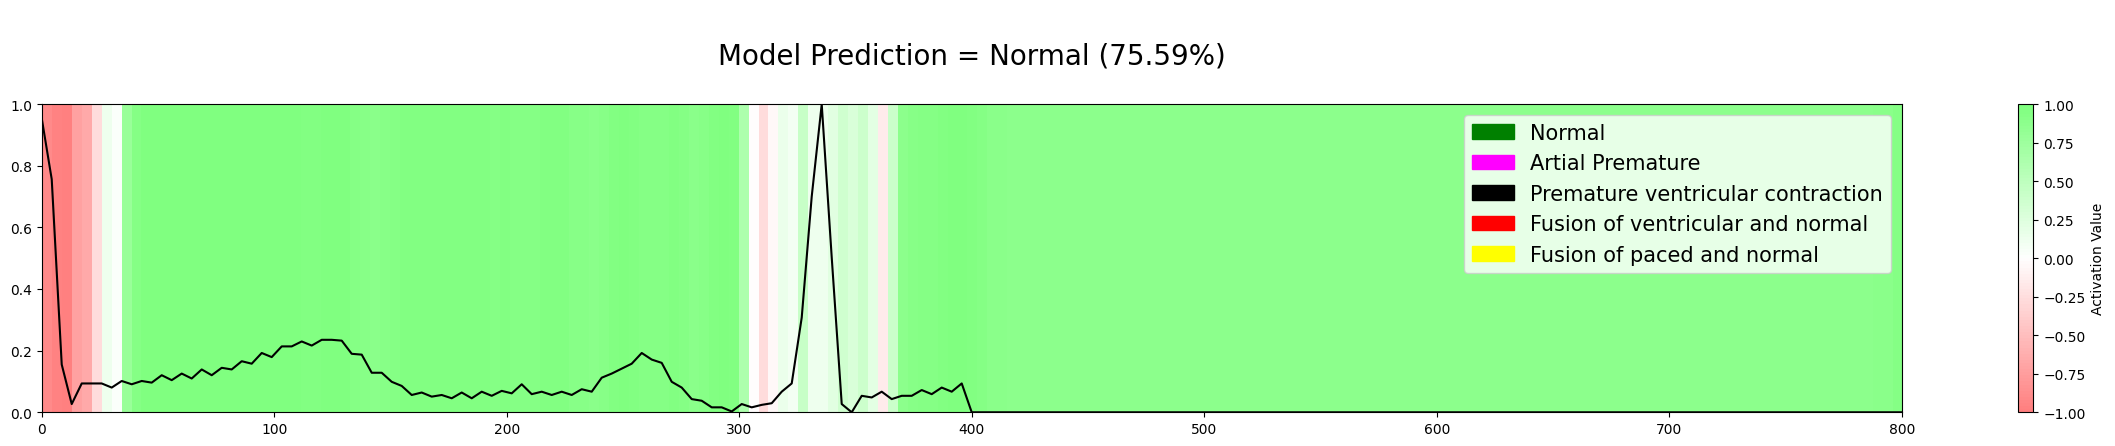

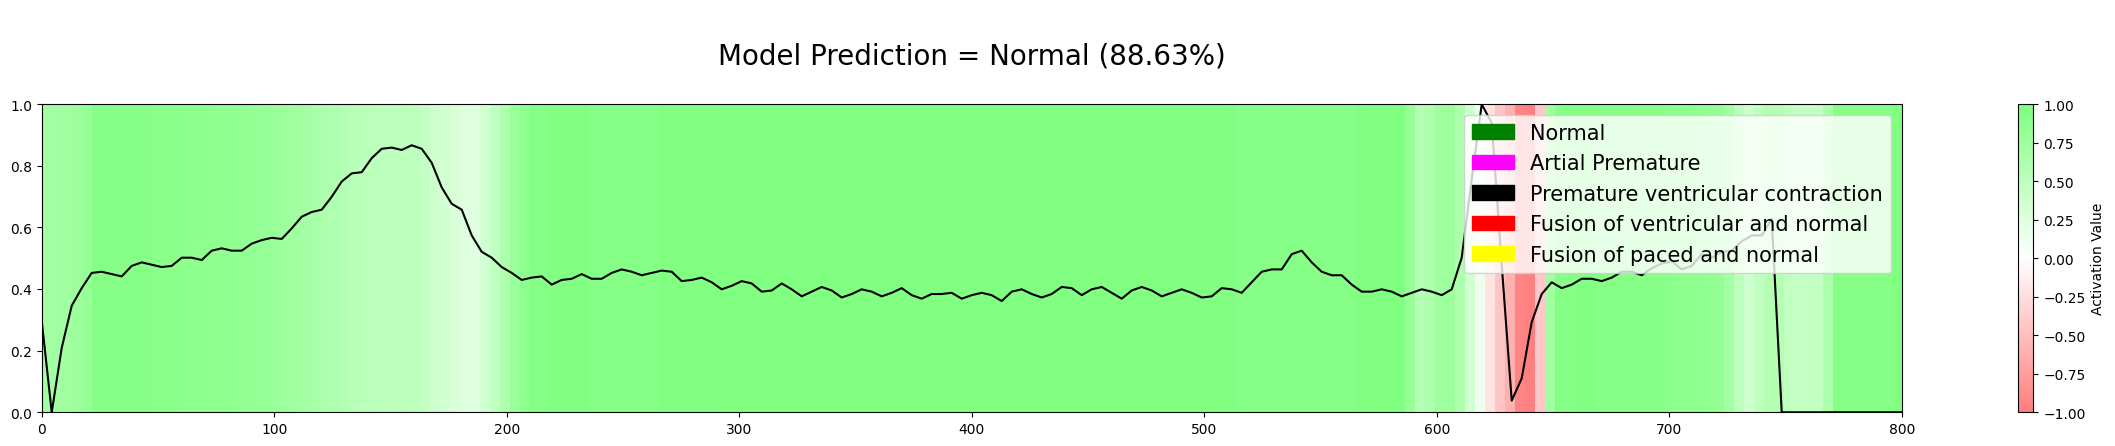

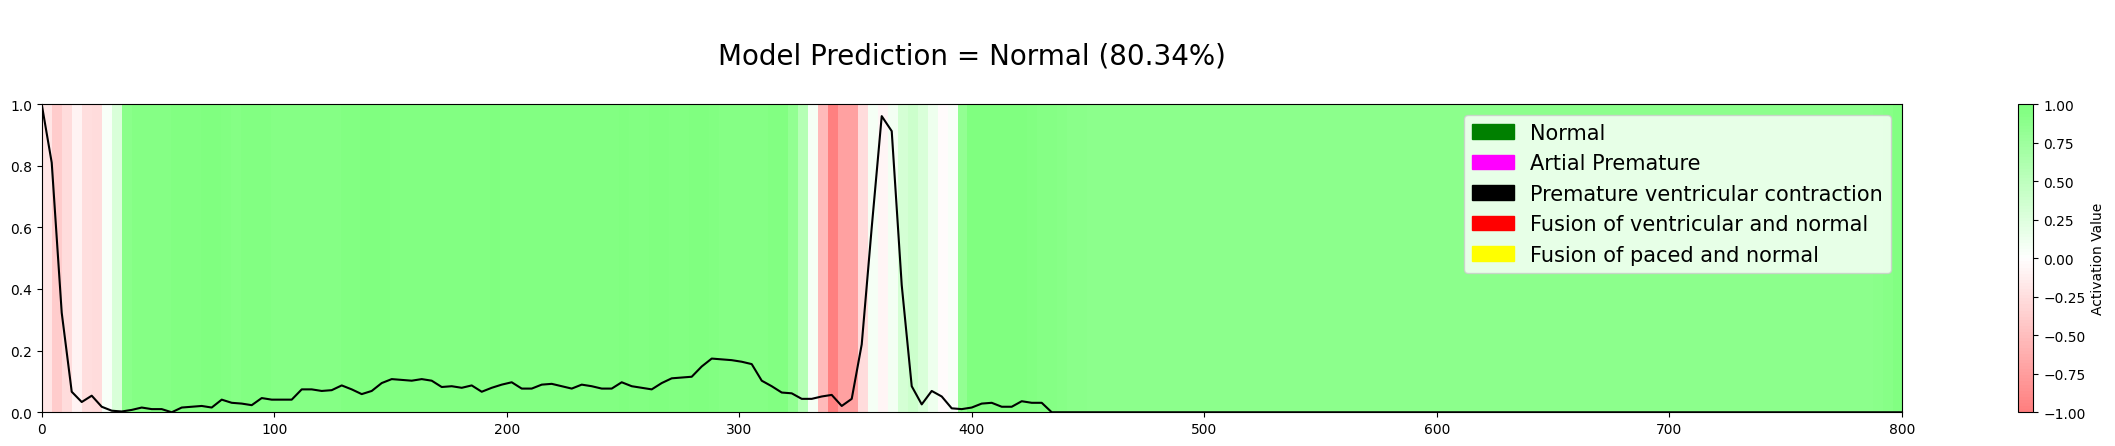

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def grad_cam(layer_name, data, class_idx):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]

    # Scale the feature map with pooled gradients
    heatmap = last_conv_layer_output * pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)

    # Normalize the heatmap to range from -1 to 1
    heatmap = (heatmap - tf.reduce_min(heatmap)) / (tf.reduce_max(heatmap) - tf.reduce_min(heatmap)) * 2 - 1
    heatmap = np.expand_dims(heatmap, 0)
    
    return heatmap

layer_name = "last_conv"
n_bins = 100  # Discretizes the interpolation into bins

# Define unique colormaps for each class
class_colormaps = [
    mcolors.LinearSegmentedColormap.from_list('class0_cmap', [(1, 0, 0), (1, 1, 1), (0, 1, 0)], N=n_bins),  # green -> white -> red
    mcolors.LinearSegmentedColormap.from_list('class1_cmap', [(0, 0, 1), (1, 1, 1), (1, 0, 1)], N=n_bins),  # blue -> white -> magenta
    mcolors.LinearSegmentedColormap.from_list('class2_cmap', [(1, 1, 0), (1, 1, 1), (0, 0, 0)], N=n_bins),  # yellow -> white -> black
    mcolors.LinearSegmentedColormap.from_list('class3_cmap', [(0, 1, 1), (1, 1, 1), (1, 0, 0)], N=n_bins),  # cyan -> white -> red
    mcolors.LinearSegmentedColormap.from_list('class4_cmap', [(0, 0, 0), (1, 1, 1), (1, 1, 0)], N=n_bins)   # black -> white -> yellow
]

class_labels = list(id_to_label.values())

# Manually define colors for legend patches
legend_colors = ['green', 'magenta', 'black', 'red', 'yellow']

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, class_labels)]

for index, row in X_test.sample(10).iterrows():
    data = np.expand_dims(row, axis=0)
    preds = model.predict(data, verbose=0)[0]
    class_idx = np.argmax(preds)
    pred_value = preds[class_idx]
    heatmap = grad_cam(layer_name, data, class_idx)
    
    plt.figure(figsize=(30, 4))
    plt.imshow(np.expand_dims(heatmap, axis=2), cmap=class_colormaps[class_idx], aspect="auto", interpolation='nearest', extent=[0, 800, row.min(), row.max()], alpha=0.5, vmin=-1, vmax=1)
    plt.plot(np.linspace(0, 800, len(row)), row, 'k', label="ECG Signal")  # Adjusted to plot data over the range 0 to 800
    plt.colorbar(label="Activation Value")
    
    label = class_labels[class_idx]
    certainty = round(pred_value * 100, 2)
    
    plt.title(f"\nModel Prediction = {label} ({certainty}%)\n", fontsize=20)
    plt.legend(handles=legend_patches, loc='upper right', fontsize=15)
    plt.xlim([0, 800])
    plt.show()
